## AML 2304 – Natural Language Processing

Instructor: havik Gandhi

Members:

* Anmolpreet Kaur (C0895954)
* Antonio Carlos De Mello Mendes (C0866063)
* Ann Margaret Silva (C0903604)
* Eduardo Jr Morales (C0900536)
* Flora Mae Villarin (C0905584)
* Maria Jessa Cruz (C0910329)
* Prescila Mora (C0896891)

Datasets:
* Bakhet, M. (2022). Amazon Book Reviews. Kaggle. Retrieved from https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews?fbclid=IwZXh0bgNhZW0CMTAAAR1CeZc5I7CIAawbB9Bq_sephstdZ04MStFp0Nr1PT7vHtkIoy-wiZ33fcs_aem_ZmFrZWR1bW15MTZieXRlcw

### **Amazon Book Recommendation with Emotion Analysis**

In [109]:
# Loading libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import torch
import pickle
from sklearn.preprocessing import OneHotEncoder

import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [130]:
# Check if the environment variable is set
filename = os.getenv('SAMPLE_DATA_FILENAME')

if filename:
    # If the filename environment variable is set, load the dataset from it
    try:
        base_dir = "../data"
        data_abr = pd.read_csv(f"{base_dir}/{filename}")        
        print(f"Loaded data from {filename}")
    except FileNotFoundError:
        print(f"File {filename} not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    # If the environment variable is not set, use existing code
    base_dir = "."

    # Load datasets from default paths
    try:
        data_titl = pd.read_csv(f"{base_dir}/books_data.csv")
        data_rate = pd.read_csv(f"{base_dir}/Books_rating.csv")
        
        # Merge datasets
        data_abr = pd.merge(data_titl, data_rate, how="outer", on="Title", validate="one_to_many")
        
        # Display the first 5 entries of the DataFrame
        print(data_abr.head())
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

                            Title  \
0  Its Only Art If Its Well Hung!   
1        Dr. Seuss: American Icon   
2        Dr. Seuss: American Icon   
3        Dr. Seuss: American Icon   
4        Dr. Seuss: American Icon   

                                         description           authors  \
0                                                NaN  ['Julie Strain']   
1  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   
2  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   
3  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   
4  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   

                                               image  \
0  http://books.google.com/books/content?id=DykPA...   
1  http://books.google.com/books/content?id=IjvHQ...   
2  http://books.google.com/books/content?id=IjvHQ...   
3  http://books.google.com/books/content?id=IjvHQ...   
4  http://books.google.com/books/content?id=IjvHQ...

In [3]:
'''
# Load datasets
base_dir = "/content/drive/MyDrive/Colab Notebooks/AmazonBookRecommendation"

# Features of books
data_titl = pd.read_csv(f'{base_dir}/books_data.csv')

# Features of rating
data_rate = pd.read_csv(f"{base_dir}/Books_rating.csv")

# Merge datasets
data_abr = pd.merge(data_titl, data_rate, how="outer", on="Title", validate="one_to_many")

# Display the first 5 entries of the DataFrame
data_abr.head()
'''

'\n# Load datasets\nbase_dir = "/content/drive/MyDrive/Colab Notebooks/AmazonBookRecommendation"\n\n# Features of books\ndata_titl = pd.read_csv(f\'{base_dir}/books_data.csv\')\n\n# Features of rating\ndata_rate = pd.read_csv(f"{base_dir}/Books_rating.csv")\n\n# Merge datasets\ndata_abr = pd.merge(data_titl, data_rate, how="outer", on="Title", validate="one_to_many")\n\n# Display the first 5 entries of the DataFrame\ndata_abr.head()\n'

#### **A. Data Cleaning:**

Inspecting more relevant Amazon book recommendations and sentiment analysis information will promote an exploration of aspects that influence how good or bad books and their authors are, based on user review contents and ratings.

The Amazon Book Recommendation Data Description includes an identifier for each book/user, ratings of reviews and books, and texts of reviews.

In [132]:
data_abr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               10 non-null     object 
 1   description         10 non-null     object 
 2   authors             10 non-null     object 
 3   image               10 non-null     object 
 4   previewLink         10 non-null     object 
 5   publisher           8 non-null      object 
 6   publishedDate       10 non-null     object 
 7   infoLink            10 non-null     object 
 8   categories          10 non-null     object 
 9   ratingsCount        8 non-null      float64
 10  Id                  10 non-null     object 
 11  Price               2 non-null      float64
 12  User_id             9 non-null      object 
 13  profileName         9 non-null      object 
 14  review/helpfulness  10 non-null     object 
 15  review/score        10 non-null     float64
 16  review/time

In [141]:
# Rename the reviews columns
data_abr.rename(columns={'review/text': 'review_text', 'review/helpfulness': 'review_helpfulness', 'review/score': 'review_score'}, inplace=True)

In [142]:
# Check the null values for relevant columns
data_abr[['Id', 'Title', 'categories', 'User_id', 'review_helpfulness', 'review_score', 'review_text']].isnull().sum()

Id                    0
Title                 0
categories            0
User_id               0
review_helpfulness    0
review_score          0
review_text           0
dtype: int64

In [143]:
# Filling columns missing values with a placeholder like "Unknown"
data_abr['categories'].fillna(('Unknown'), inplace = True)
data_abr['User_id'].fillna(('Unknown'), inplace = True)

# Dropping rows with missing values
data_abr.dropna(subset=['Title', 'review_text'], inplace=True)

In [144]:
# Check the null values again for relevant columns
data_abr[['Title', 'categories', 'User_id', 'review_helpfulness', 'review_score', 'review_text']].isnull().sum()

Title                 0
categories            0
User_id               0
review_helpfulness    0
review_score          0
review_text           0
dtype: int64

In [145]:
# Select relevant column for use in the dataframe
data_abr_relevant = data_abr[['Id', 'categories', 'User_id', 'review_helpfulness', 'review_score', 'review_text']]

In [146]:
# Check for duplicated reviews
data_abr_relevant.describe(include='all')

,Id,categories,User_id,review_helpfulness,review_score,review_text
count,10,10,10,10,10.000000,10
unique,10,7,10,7,NaN,10
top,0739107305,['Fiction'],A3RNYHQZ5VQ53C,0/0,NaN,This book is the finest review of juvenile jus...
freq,1,4,1,4,NaN,1
mean,NaN,NaN,NaN,NaN,4.100000,NaN
std,NaN,NaN,NaN,NaN,1.286684,NaN
min,NaN,NaN,NaN,NaN,1.000000,NaN
25%,NaN,NaN,NaN,NaN,4.000000,NaN
50%,NaN,NaN,NaN,NaN,4.500000,NaN
75%,NaN,NaN,NaN,NaN,5.000000,NaN


The Id column contains 2,999,784 rows with 221,989 unique values. In contrast, the review_text column also has 2,999,784 rows, with 2,062,627 unique entries. This means there are 937,157 duplicate entries in the review_text column.

In [147]:
# Check for duplicate entries
data_abr_relevant.review_text.duplicated(keep = "first").value_counts()

review_text
False    10
Name: count, dtype: int64

In [148]:
# Drop duplicate entries
data_abr_relevant.drop_duplicates(subset = "review_text", keep = "first", inplace=True, ignore_index=True)
data_abr_relevant.review_text.describe()

C:\Users\admin\AppData\Local\Temp\ipykernel_21716\4163860825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant.drop_duplicates(subset = "review_text", keep = "first", inplace=True, ignore_index=True)


count                                                    10
unique                                                   10
top       This book is the finest review of juvenile jus...
freq                                                      1
Name: review_text, dtype: object

##### Text Processing

The following functions convert text into a representations that is better suited for processing and analysis in NLP, using text cleaning for removing stop words, punctuation, and other non-essential elements.

Also, tokenization divides strings containing multiple words into smaller parts. Then, eliminate common words from a piece of text using stop words, and use stemming to normalize words by reducing them to their base form.

In [149]:
# Data Preprocessing Functions
nltk.download('wordnet')
# Function to text cleaning
def clean_text(text):

    # Check if the text is a string
     if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
        text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # Remove URLs
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = text.lower()  # Convert to lowercase
        return text
     else:
        return ""

# Function to tokenize the words, remove stop words, and treat normalization
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Normalize words by using Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [150]:
# Convert all text reviews to strings
data_abr_relevant['review_text'] = data_abr_relevant['review_text'].astype(str)

# Apply cleaning to the 'processed_text' column
data_abr_relevant['processed_text'] = data_abr_relevant['review_text'].apply(clean_text)

# Remove rows where processed_text is empty after cleaning
data_abr_relevant = data_abr_relevant[data_abr_relevant['processed_text'].str.strip().astype(bool)]

C:\Users\admin\AppData\Local\Temp\ipykernel_21716\2645685360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant['review_text'] = data_abr_relevant['review_text'].astype(str)
C:\Users\admin\AppData\Local\Temp\ipykernel_21716\2645685360.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant['processed_text'] = data_abr_relevant['review_text'].apply(clean_text)


##### Text Normalization

In [152]:
# Tokenize the text into separate words

# Convert all the text reviews to strings
data_abr_relevant['processed_text'] = data_abr_relevant['processed_text'].astype(str)

# Apply preprocessing to the 'processed_text' column
data_abr_relevant["tokens"] = data_abr_relevant["processed_text"].apply(preprocess_text)
data_abr_relevant.head()

,Id,categories,User_id,review_helpfulness,review_score,review_text,processed_text,tokens
0,0739107305,['Social Science'],A3RNYHQZ5VQ53C,0/0,5.0,This book is the finest review of juvenile jus...,this book is the finest review of juvenile jus...,"[book, finest, review, juvenile, justice, yet,..."
1,B000NYRZ42,['Christmas stories'],A11V2KYQGQZD9X,0/0,4.0,The convenience of having this on Kindle is gr...,the convenience of having this on kindle is gr...,"[convenience, kindle, great, handy, get, chanc..."
2,B000GSDWJW,['Fiction'],A3C9C2VDRU35O2,1/4,5.0,First of all to those people who think this bo...,first of all to those people who think this bo...,"[first, people, think, book, blasphemousits, b..."
3,B000MOPSSS,['Fiction'],A35L7OILK3N53S,1/1,5.0,I still very much enjoy this book decades afte...,i still very much enjoy this book decades afte...,"[still, much, enjoy, book, decade, read, first..."
4,0137549202,['Mathematics'],A1B36XQRYO88TO,28/31,1.0,I am currently taking a first course in DSP wh...,i am currently taking a first course in dsp wh...,"[currently, taking, first, course, dsp, oamps,..."


##### **Analyzing the distribuition of the words within the dataset**

Analyze the vocabulary and its distribution to use in feature selection, understand document content, or prepare data for modeling, and visualize the results through plotting.

In [153]:
# Get a list of all words in the tokenized texts
all_words = [word for tokens in data_abr_relevant["tokens"] for word in tokens]

# Get a list of text lengths in the tokenized texts
text_lengths = [len(tokens) for tokens in data_abr_relevant["tokens"]]

# List all unique words in the dataset and sort them for future convenience
vocab = sorted(set(all_words))

# Print the total number of words and the vocabulary size
print(f'Total number of words: {len(all_words)}')
print(f'Vocabulary size: {len(vocab)}')

# Print the maximum sentence length
print(f'Max text length: {max(text_lengths)}')

Total number of words: 707
Vocabulary size: 449
Max text length: 179


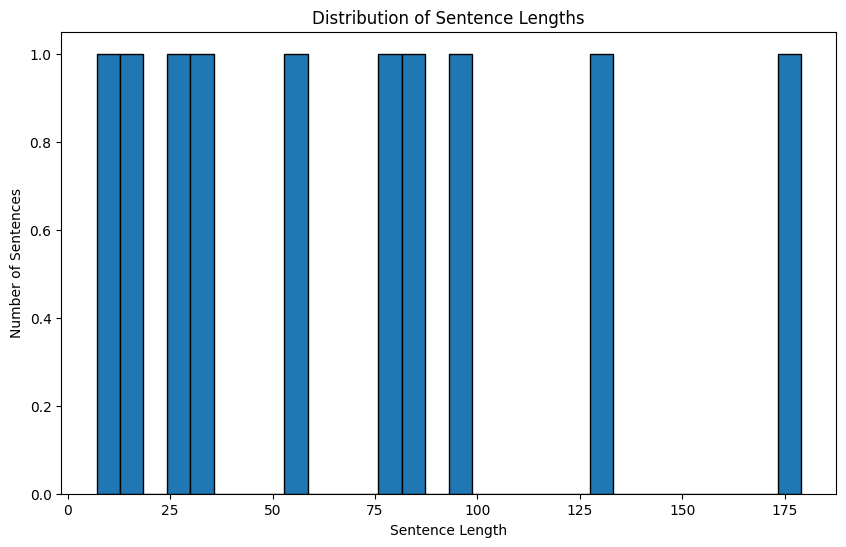

In [154]:
import matplotlib.pyplot as plt

# Define the figure size and create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the labels for the x and y axes
ax.set_xlabel('Sentence Length')
ax.set_ylabel('Number of Sentences')

# Plot the histogram of sentence lengths
ax.hist(text_lengths, bins=30, edgecolor='black')

# Set the title for the plot
ax.set_title('Distribution of Sentence Lengths')

# Show the plot
plt.show()

In [155]:
data_abr_relevant.head()

,Id,categories,User_id,review_helpfulness,review_score,review_text,processed_text,tokens
0,0739107305,['Social Science'],A3RNYHQZ5VQ53C,0/0,5.0,This book is the finest review of juvenile jus...,this book is the finest review of juvenile jus...,"[book, finest, review, juvenile, justice, yet,..."
1,B000NYRZ42,['Christmas stories'],A11V2KYQGQZD9X,0/0,4.0,The convenience of having this on Kindle is gr...,the convenience of having this on kindle is gr...,"[convenience, kindle, great, handy, get, chanc..."
2,B000GSDWJW,['Fiction'],A3C9C2VDRU35O2,1/4,5.0,First of all to those people who think this bo...,first of all to those people who think this bo...,"[first, people, think, book, blasphemousits, b..."
3,B000MOPSSS,['Fiction'],A35L7OILK3N53S,1/1,5.0,I still very much enjoy this book decades afte...,i still very much enjoy this book decades afte...,"[still, much, enjoy, book, decade, read, first..."
4,0137549202,['Mathematics'],A1B36XQRYO88TO,28/31,1.0,I am currently taking a first course in DSP wh...,i am currently taking a first course in dsp wh...,"[currently, taking, first, course, dsp, oamps,..."


In [156]:
# Save data cleaning file to local
data_abr_relevant.to_csv(f"{base_dir}/data_cleaned.csv")

In [161]:
# Rename the reviews columns
data_abr.rename(columns={'User_id': 'user_id', 'publishedDate': 'published_date', 'review/text': 'review_text', 'review/helpfulness': 'review_helpfulness', 'review/score': 'review_score'}, inplace=True)

# Dropping rows with missing values
data_abr.dropna(subset=['Title', 'categories', 'review_text', 'published_date', 'user_id'], inplace=True)

# Select relevant column for use in the dataframe
data_abr_relevant = data_abr[['Id', 'categories', 'user_id', 'published_date', 'review_helpfulness', 'review_score', 'review_text']]

# Split review/helpfulness column into helpful and Total
data_abr_relevant[['useful', 'total_of_person']] = data_abr_relevant['review_helpfulness'].str.split('/', expand=True)

# Select relevant columns for use in the dataframe
data_abr_relevant = data_abr_relevant[['Id','categories', 'published_date', 'user_id', 'useful', 'total_of_person', 'review_score', 'review_text']]

# Save raw review text file to local adding user_id
data_books_with_raw_review = data_abr_relevant[['Id','categories', 'published_date', 'user_id', 'useful', 'total_of_person', 'review_score', 'review_text']]
data_books_with_raw_review.to_csv(f"{base_dir}/books_with_raw_review.csv")

C:\Users\admin\AppData\Local\Temp\ipykernel_21716\2304922730.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant[['useful', 'total_of_person']] = data_abr_relevant['review_helpfulness'].str.split('/', expand=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_21716\2304922730.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant[['useful', 'total_of_person']] = data_abr_relevant['review_helpfulness'].str.split('/', expand=True)
